
## Execute computer vision inference on large videos using managed queues, notifications, and automatic scaling with Amazon SageMaker Asynchronous Endpoints

### Table of Contents

* Background
* Setup
* Download and trigger pre-trained maskrcnn model on a sample image
* Create model archive and upload to S3
* Create SageMaker model with PyTorch inference container
* Real time hosted endpoint deployment and inference
* Create Asynchronous inference endpoints
* Invoke asynchronous endpoint
* Enable autoscaling
* Cleanup

### Background

AWS customers are increasingly using computer vision (CV) models on large input payloads that can take a few minutes of processing time. For example, space technology companies work with a stream of high resolution satellite imagery to detect particular objects of interest. Similarly, healthcare companies process high resolution biomedical images or videos like echocardiograms to detect anomalies. Also, media companies scan images and videos uploaded by their customers to ensure they are compliant and without copyright violations. These applications receive a burst of incoming traffic at different times in the day and require near real time processing with completion notifications at a low cost. 

In this notebook, we serve a PyTorch Computer Vision model with SageMaker asynchronous inference endpoints to process a burst of traffic of large input payload videos. We demonstrate the new capabilities of an internal queue with user defined concurrency and completion notifications. We configure autoscaling of instances including  scaling down to 0 when traffic subsides and scale back up as the request queue fills up. We use [SageMaker’s pre-built TorchServe container](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html) with a custom inference script for preprocessing the videos before model invocation. 

   1. Large payload input of a high resolution video segment of 70 MB
   2. Large payload output from a PyTorch pre-trained mask-rcnn model 
   3. Large response time from the model of 40 seconds 
   4. Auto-queuing of inference requests with asyncrhonous inference
   5. Notifications of completed requests via SNS 
   6. Auto-scaling of endpoints based on queue length metric with minimum value set to 0

![Workflow](images/Async_Diagram.png)

### Setup


If you run this notebook in SageMaker Studio, you need to make sure ipywidgets is installed and restart the kernel, so please uncomment the code in the next cell, and run it.

In [1]:
# %%capture
# import IPython
# import sys

# !{sys.executable} -m pip install ipywidgets
# IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used

In [2]:
!python -m pip install --upgrade pip --quiet
!pip install -U awscli --quiet
!pip install torch==1.8.0 --quiet 
!pip install torchvision==0.9.0 --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotoco

In [4]:
!pip install -U sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 442 kB 21.3 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.59.1.post0-py2.py3-none-any.whl size=618622 sha256=e6e91fe56c8f1fa80860ea30fbf383232c28655e13b2013b06b1f082bb114d41
  Stored in directory: /root/.cache/pip/wheels/2a/f3/43/3202e1a2580c37e331ec9381a00493d6a9a5cbe78d5f7f7c8d
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.54.0
    Uninstalling sagemaker-2.54.0:
      Successfully uninstalled sagemaker-2.54.0


In [3]:
import torch
import torchvision
import torchvision.models as models
import sagemaker
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base
from sagemaker.pytorch import PyTorchModel
import boto3
import datetime
import time
from time import strftime,gmtime
import json
import os
import urllib
import sys
import io

role = get_execution_role()
boto_session = boto3.session.Session()
sm_session = sagemaker.session.Session()
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")
sns_client = boto3.client('sns')
region = boto_session.region_name
bucket = sm_session.default_bucket()
prefix = 'async-inference-maskrcnn'

print(region)
print(role)
print(bucket)
print(prefix)

us-west-1
arn:aws:iam::757967535041:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole
sagemaker-us-west-1-757967535041
async-inference-maskrcnn


In [45]:

datetime.now()

datetime.datetime(2021, 9, 14, 19, 31, 59, 791752)

In [5]:
print(torch.__version__)
print(torchvision.__version__)

1.8.0
0.9.0


Specify your IAM role. Go the AWS IAM console (https://console.aws.amazon.com/iam/home) and add the following policies to your IAM Role:
* SageMakerFullAccessPolicy
* Amazon S3 access: Apply this to get and put objects in your Amazon S3 bucket. Replace `bucket_name` with the name of your Amazon S3 bucket:      

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:GetObject",
                "s3:PutObject",
                "s3:AbortMultipartUpload",
                "s3:ListBucket"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:s3:::bucket_name/*"
        }
    ]
}
```

* (Optional) Amazon SNS access: Add `sns:Publish` on the topics you define. Apply this if you plan to use Amazon SNS to receive notifications.

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "sns:Publish"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:sns:us-east-2:123456789012:MyTopic"
        }
    ]
}
```

* (Optional) KMS decrypt, encrypt if your Amazon S3 bucket is encrypte.

### Download and trigger maskrcnn model on a sample image

Using pre-trained maskrcnn resnet 50 model

In [6]:
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [8]:
from PIL import Image
import torchvision.transforms as transforms

img = io.BytesIO(open('images/birds.jpg', 'rb').read())
birds_image = Image.open(img).convert('RGB')
birds_image = transforms.ToTensor()(birds_image)
print(type(birds_image))

<class 'torch.Tensor'>


In [9]:
model.eval()
outputs = model([birds_image])
output = outputs[0]

In [10]:
#Print output
res = []
for output in outputs:
    res.append({'boxes':output['boxes'].detach().numpy().tolist(),'labels':output['labels'].detach().numpy().tolist(),'scores':output['scores'].detach().numpy().tolist()})
print(json.dumps(res))

[{"boxes": [[33.49821472167969, 284.2646179199219, 1048.5108642578125, 810.3135986328125], [1107.794677734375, 256.5046081542969, 1977.7801513671875, 898.3372802734375], [880.5606079101562, 677.7882690429688, 1897.28515625, 1180.1151123046875], [836.5274047851562, 260.999755859375, 2045.798828125, 1182.13671875], [20.251781463623047, 508.6960754394531, 678.1981201171875, 850.1907348632812], [966.52587890625, 446.9561767578125, 1870.8499755859375, 991.31005859375], [895.2606811523438, 830.11376953125, 1660.05810546875, 965.4442749023438], [23.06002426147461, 543.3861083984375, 359.94970703125, 823.0071411132812], [892.9069213867188, 859.9248657226562, 1554.46337890625, 1094.5997314453125], [411.6666259765625, 565.1069946289062, 526.0043334960938, 700.0460815429688], [170.63555908203125, 251.11587524414062, 1672.8924560546875, 898.5183715820312]], "labels": [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], "scores": [0.9990274906158447, 0.9958305954933167, 0.991154670715332, 0.85194283723831

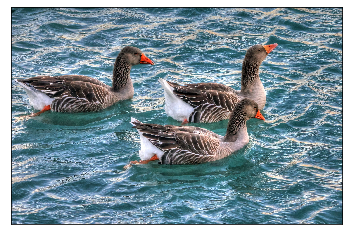

In [11]:
#Print original image
from torchvision.utils import make_grid
grid = make_grid([birds_image])
show(grid)

Print original image with model output boxes

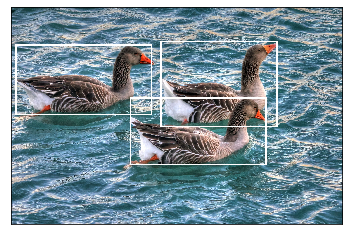

In [12]:
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
score_threshold = .9
birds_with_boxes = [
    draw_bounding_boxes(read_image('images/birds.jpg'), boxes=output['boxes'][output['scores'] > score_threshold], width=10)
]
show(birds_with_boxes)

### Create model archive and upload to S3

In [13]:
!mkdir model_and_code
torch.save(model, 'model_and_code/model.pth')
!mkdir model_and_code/code
!cp ./code/* model_and_code/code
!tar cvzf model.tar.gz -C model_and_code/ . 

./
./model.pth
./code/
./code/requirements.txt
./code/inference.py


In [14]:
from sagemaker.s3 import S3Uploader
file_key = 'model.tar.gz'
model_artifact = S3Uploader.upload(file_key,'s3://{}/{}/model'.format(bucket, prefix))
print(model_artifact)

s3://sagemaker-us-west-1-757967535041/async-inference-maskrcnn/model/model.tar.gz


### Create SageMaker model with PyTorch inference container

In [15]:
from sagemaker.image_uris import retrieve

deploy_instance_type = 'ml.g4dn.xlarge'
pytorch_inference_image_uri = retrieve('pytorch',
                                       region,
                                       version='1.7.1',
                                       py_version='py3',
                                       instance_type = deploy_instance_type,
                                       accelerator_type=None,
                                       image_scope='inference')
print(pytorch_inference_image_uri)

763104351884.dkr.ecr.us-west-1.amazonaws.com/pytorch-inference:1.7.1-gpu-py3


In [16]:
container = pytorch_inference_image_uri
model_name = 'sagemaker-maskrcnn-{0}'.format(str(int(time.time())))
print(container)
print(model_name)

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': container,
        'ModelDataUrl': model_artifact,
        'Environment': {
            'TS_MAX_REQUEST_SIZE': '100000000', #default max request size is 6 Mb for torchserve, need to update it to support the 70 mb input payload
            'TS_MAX_RESPONSE_SIZE': '100000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        }
    },    
)

763104351884.dkr.ecr.us-west-1.amazonaws.com/pytorch-inference:1.7.1-gpu-py3
sagemaker-maskrcnn-1631646511


### Real time hosted endpoint deployment and inference

Create an endpoint config name. Here we create one based on the date so it we can search endpoints based on creation time.

In [17]:
print(model_name)
endpoint_config_name = f"maskrcnnEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1
        }
    ]
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

sagemaker-maskrcnn-1631646511
Created EndpointConfig: arn:aws:sagemaker:us-west-1:757967535041:endpoint-config/maskrcnnendpointconfig-2021-09-14-19-08-48


In [18]:
endpoint_name = f"sm-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)

In [19]:
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Waiting for endpoint to create...
Endpoint Status: InService


In [20]:
ep= endpoint_name
feed_data = open('images/birds.jpg', 'rb')
sm_runtime = boto3.Session().client('sagemaker-runtime')
r = sm_runtime.invoke_endpoint(EndpointName=ep, Body=feed_data)

In [21]:
print(r['Body'].read())

b'[{"boxes": [[31.00066375732422, 185.1052703857422, 433.9681091308594, 501.9935302734375], [346.3128967285156, 410.75592041015625, 789.4537963867188, 749.7699584960938], [360.08319091796875, 139.71994018554688, 834.5388793945312, 699.4168701171875], [445.6692199707031, 325.65277099609375, 718.961181640625, 566.6964111328125], [466.4849853515625, 166.37548828125, 797.0263061523438, 537.3280639648438], [484.1777648925781, 443.4866943359375, 708.4545288085938, 721.5338134765625], [14.377577781677246, 314.89288330078125, 362.8853454589844, 531.799072265625], [126.4969482421875, 429.94671630859375, 793.076416015625, 846.5239868164062], [95.3680419921875, 166.49591064453125, 635.573486328125, 595.076171875], [21.680585861206055, 200.88897705078125, 458.9969787597656, 774.1900634765625]], "labels": [16, 16, 16, 16, 16, 16, 16, 16, 16, 16], "scores": [0.9995611310005188, 0.9974155426025391, 0.9939456582069397, 0.22476854920387268, 0.1833336502313614, 0.12950502336025238, 0.11609508097171783, 

### Create Asynchronous inference endpoints

Unlike real time hosted endpoints, asynchronous endpoints support scaling
down instances to 0 by setting the minimum capacity to 0. With this feature, we can scale
down to 0 instances when there is no traffic and pay only when the payloads arrive. Let's create an asynchronous endpoint to see it in action below -

In [22]:
bucket_prefix = "async-inference-blog"
resource_name = "AsyncInferenceDemo-SNS"

Create Error and Success SNS topics

In [23]:
response = sns_client.create_topic(Name="Async-Demo-ErrorTopic")
error_topic= response['TopicArn']
print(error_topic)

arn:aws:sns:us-west-1:757967535041:Async-Demo-ErrorTopic


In [24]:
response = sns_client.create_topic(Name="Async-Demo-SuccessTopic")
success_topic = response['TopicArn']
print(success_topic)

arn:aws:sns:us-west-1:757967535041:Async-Demo-SuccessTopic


List SNS topics

In [32]:
response = sns_client.list_topics()
topics = response["Topics"]
print(topics)

[{'TopicArn': 'arn:aws:sns:us-west-2:757967535041:Async-Demo-ErrorTopic'}, {'TopicArn': 'arn:aws:sns:us-west-2:757967535041:Async-Demo-SuccessTopic'}]


Optionally Subscribe to an SNS topic

In [25]:
#Note: Replace with your email id

# email_id = 'your-email@domain-name.com'
# email_sub_1 = sns_client.subscribe(
#     TopicArn=success_topic,
#     Protocol='email',
#     Endpoint=email_id)

# email_sub_2 = sns_client.subscribe(
#     TopicArn=error_topic,
#     Protocol='email',
#     Endpoint=email_id)

#Note: You will need to confirm by clicking on the email you recieve to complete the subscription

Create an endpoint config name. Here we create one based on the date so it we can search endpoints based on creation time.

In [26]:
print(model_name)
endpoint_config_name = f"PyTorchAsyncEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{bucket}/{bucket_prefix}/output",
            #  Optionally specify Amazon SNS topics
            "NotificationConfig": {
              "SuccessTopic": success_topic,
              "ErrorTopic": error_topic,
            }
        },
        "ClientConfig": {
            "MaxConcurrentInvocationsPerInstance": 2
        }
    }
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

sagemaker-maskrcnn-1631646511
Created EndpointConfig: arn:aws:sagemaker:us-west-1:757967535041:endpoint-config/pytorchasyncendpointconfig-2021-09-14-19-18-23


In [27]:
endpoint_name = f"sm-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_response = sm_client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
print(f"Creating Endpoint: {create_endpoint_response['EndpointArn']}")

Creating Endpoint: arn:aws:sagemaker:us-west-1:757967535041:endpoint/sm-2021-09-14-19-18-26


In [28]:
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Waiting for endpoint to create...
Endpoint Status: InService


### Upload input video file

In [29]:
def upload_file(input_location):
    prefix = f"{bucket_prefix}/input"
    return sm_session.upload_data(
        input_location, 
        bucket=sm_session.default_bucket(),
        key_prefix=prefix, 
        extra_args={"ContentType": "video/mp4"})

In [30]:
input_1_location = "videos/ducks.mp4"
input_1_s3_location = upload_file(input_1_location)

In [31]:
print(input_1_s3_location)

s3://sagemaker-us-west-1-757967535041/async-inference-blog/input/ducks.mp4


In [32]:
print(endpoint_name)

sm-2021-09-14-19-18-26


### Invoke asynchronous endpoint

In [33]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_1_s3_location)
output_location = response['OutputLocation']
print(f"OutputLocation: {output_location}")

OutputLocation: s3://sagemaker-us-west-1-757967535041/async-inference-blog/output/6a9815d0-43b2-4345-80e1-ed50890979a2.out


In [34]:
from botocore.exceptions import ClientError

def get_output(output_location):
    output_url = urllib.parse.urlparse(output_location)
    bucket = output_url.netloc
    key = output_url.path[1:]
    while True:
        try:
            return sm_session.read_s3_file(bucket=output_url.netloc, key_prefix=output_url.path[1:])
        except ClientError as e:
            if e.response['Error']['Code'] == 'NoSuchKey':
                print("waiting for output...")
                time.sleep(2)
                continue
            raise


In [35]:
output = get_output(output_location)
print(f"Output size in bytes: {((sys.getsizeof(output)))}")

waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
Output size in bytes: 54931


### Trigger 10 asynchronous requests on a single instance 

In [36]:
inferences = []
for i in range(1,10):
    start = time.time()
    response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_1_s3_location)
    output_location = response["OutputLocation"]
    inferences += [(input_1_s3_location, output_location)]
    time.sleep(0.5)
print("\Async invocations for Pytorch serving default: \n")

for input_file, output_location in inferences:
    output = get_output(output_location)
    print(f"Input File: {input_file}, Output location: {output_location}")

\Async invocations for Pytorch serving default: 

waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
Input File: s3://sagemaker-us-west-1-757967535041/async-inference-blog/input/ducks.mp4, Output location: s3://sagemaker-us-west-1-757967535041/async-inference-blog/output/e5e31742-ca28-43e5-bbdd-82ce965a56d6.out
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
Input File: s3://sagemaker-us-west-1-757967535041/async-inference-blog/input/ducks.mp4, Output location: s3://sagemaker-us-west-1-757967535041/async-inference-blog/output/61668cfd-2b16-4aed-854f-c3bb97d524f4.out
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output...
waiting for output..

### Enable autoscaling

In [37]:
client = boto3.client('application-autoscaling') # Common class representing Application Auto Scaling for SageMaker amongst other services

resource_id='endpoint/' + endpoint_name + '/variant/' + 'variant1' # This is the format in which application autoscaling references the endpoint

response = client.register_scalable_target(
    ServiceNamespace='sagemaker', 
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=0,  
    MaxCapacity=5
)

response = client.put_scaling_policy(
    PolicyName='Invocations-ScalingPolicy',
    ServiceNamespace='sagemaker', # The namespace of the AWS service that provides the resource. 
    ResourceId=resource_id, # Endpoint name 
    ScalableDimension='sagemaker:variant:DesiredInstanceCount', # SageMaker supports only Instance Count
    PolicyType='TargetTrackingScaling', # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 5.0, # The target value for the metric. 
        'CustomizedMetricSpecification': {
            'MetricName': 'ApproximateBacklogSizePerInstance',
            'Namespace': 'AWS/SageMaker',
            'Dimensions': [
                {'Name': 'EndpointName', 'Value': endpoint_name }
            ],
            'Statistic': 'Average',
        },
        'ScaleInCooldown': 120, # The cooldown period helps you prevent your Auto Scaling group from launching or terminating 
                                # additional instances before the effects of previous activities are visible. 
                                # You can configure the length of time based on your instance startup time or other application needs.
                                # ScaleInCooldown - The amount of time, in seconds, after a scale in activity completes before another scale in activity can start. 
        'ScaleOutCooldown': 120 # ScaleOutCooldown - The amount of time, in seconds, after a scale out activity completes before another scale out activity can start.
        
        # 'DisableScaleIn': True|False - ndicates whether scale in by the target tracking policy is disabled. 
                            # If the value is true , scale in is disabled and the target tracking policy won't remove capacity from the scalable resource.
    }
)

In [38]:
print(response)

{'PolicyARN': 'arn:aws:autoscaling:us-west-1:757967535041:scalingPolicy:7829f254-65b5-40fd-a34c-6241591d3cef:resource/sagemaker/endpoint/sm-2021-09-14-19-18-26/variant/variant1:policyName/Invocations-ScalingPolicy', 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/sm-2021-09-14-19-18-26/variant/variant1-AlarmHigh-58b9df5f-e100-4865-a493-526c74ed3056', 'AlarmARN': 'arn:aws:cloudwatch:us-west-1:757967535041:alarm:TargetTracking-endpoint/sm-2021-09-14-19-18-26/variant/variant1-AlarmHigh-58b9df5f-e100-4865-a493-526c74ed3056'}, {'AlarmName': 'TargetTracking-endpoint/sm-2021-09-14-19-18-26/variant/variant1-AlarmLow-47819711-b5fc-4f38-aec8-a708ca9cba10', 'AlarmARN': 'arn:aws:cloudwatch:us-west-1:757967535041:alarm:TargetTracking-endpoint/sm-2021-09-14-19-18-26/variant/variant1-AlarmLow-47819711-b5fc-4f38-aec8-a708ca9cba10'}], 'ResponseMetadata': {'RequestId': '16670c2b-83de-4b2e-9e69-7aa9d93ed25d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '16670c2b-83de-4b2e-9e69-7aa9d93ed2

### Trigger 1000 asynchronous invocations with autoscaling from 1 to 5 and then scale down to 0 on completion

Optionally [delete the SNS topic](https://boto3.amazonaws.com/v1/documentation/api/1.9.42/reference/services/sns.html#SNS.Client.delete_topic) to avoid flooding of notifications on 1000 invocations below 

In [39]:
print(endpoint_name)
for i in range(1,1000):
    response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_1_s3_location)
print("\Async invocations for Pytorch serving with auotscaling \n")

sm-2021-09-14-19-18-26
\Async invocations for Pytorch serving with auotscaling 



Plot graphs from CloudWatch Metrics

In [40]:
import pandas as pd
cw = boto3.Session().client("cloudwatch")

In [58]:
import datetime
from datetime import datetime,timedelta
def get_sagemaker_metrics(endpoint_name,
                          endpoint_config_name,
                          variant_name,
                          metric_name,
                          statistic,
                          start_time,
                          end_time):
    dimensions = [
        {
            "Name": "EndpointName",
            "Value": endpoint_name
        },
        {
            "Name": "VariantName",
            "Value": variant_name
        }
    ]
    if endpoint_config_name is not None:
        dimensions.append({
            "Name": "EndpointConfigName",
            "Value": endpoint_config_name
        })
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistic],
        Dimensions=dimensions
    )
    rename = endpoint_config_name if endpoint_config_name is not None else 'ALL'
    return pd.DataFrame(metrics["Datapoints"])\
            .sort_values("Timestamp")\
            .set_index("Timestamp")\
            .drop(["Unit"], axis=1)\
            .rename(columns={statistic: rename})

def plot_endpoint_model_latency_metrics(endpoint_name, endpoint_config_name, variant_name, start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metric_name = "ModelLatency"
    statistic = "Average"
    metrics_variants = get_sagemaker_metrics(
        endpoint_name,
        endpoint_config_name,
        variant_name,
        metric_name, 
        statistic,
        start_time,
        end_time)
    metrics_variants.plot(title=f"{metric_name}-{statistic}")
    return metrics_variants

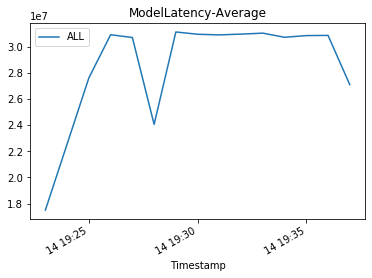

In [60]:
model_latency_metrics = plot_endpoint_model_latency_metrics(endpoint_name, None, "variant1")

Similarly, we plot other Cloud Watch Metrics associated with the Endpoint as shown below

### Cloud watch metrics - Approximate Backlog Size and Approximate Backlog Size per instance 
The backlog grows from 0 to 1000 when the burst of traffic is invoked. Then, the endpoint autoscales every 120 seconds upto the max number of instances = 5. The Backlog size per instance changes rapidly during autoscaling. At max number of instances, the queue backlog reduces at about 1 invocation per minute and finally reaches 0. 

![title](images/backlog_size_metrics.png)

The model latency for 2 concurrent invocations is approximately 80 seconds 

![title](images/model_latency_metrics.png)

The instances autoscale down to 0 once the queue size goes down to 0

![title](images/instance_count_0.png)

### Cleanup

If you enabled auto-scaling for your endpoint, ensure you deregister the endpoint as a scalable target before deleting the endpoint. To do this, please uncomment the cell below and run :

In [64]:
# response = client.deregister_scalable_target(
#     ServiceNamespace='sagemaker',
#     ResourceId='resource_id',
#     ScalableDimension='sagemaker:variant:DesiredInstanceCount'
# )

Endpoints should be deleted when no longer in use, since (per the [SageMaker pricing page](https://aws.amazon.com/sagemaker/pricing/)) they're billed by time deployed

In [65]:
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '47e3d998-a669-403f-a78c-cdbc2416815b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '47e3d998-a669-403f-a78c-cdbc2416815b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 14 Sep 2021 19:42:56 GMT'},
  'RetryAttempts': 0}}

You may also want to delete any other resources you might have created such as SNS topics, S3 objects, etc.